In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def load_data(dataset_path):
    
    with open(dataset_path, 'r') as fp:
        data = json.load(fp)
    
    X = np.array(data['mfcc'])
    y = np.array(data['labels'])
    z = np.array(data['mapping'])
    
    return X, y, z


In [2]:
DATASET_PATH = 'data.json'

X, y, cats = load_data(DATASET_PATH)

In [3]:
X[0].shape

(130, 13)

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
X_train.shape

(31955, 130, 13)

In [7]:
X_test.shape

(7989, 130, 13)

In [8]:
# Adding an extra channel for the CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
input_shape

(130, 13, 1)

In [10]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(BatchNormalization())


model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))



model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 9, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 4, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 4, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 2, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 1, 64)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 1, 64)         256       
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[stop])

Epoch 1/50
500/500 [==============================] - 66s 132ms/step - loss: 1.6974 - accuracy: 0.4175 - val_loss: 1.2312 - val_accuracy: 0.5566
Epoch 2/50
500/500 [==============================] - 66s 132ms/step - loss: 1.2359 - accuracy: 0.5717 - val_loss: 1.0375 - val_accuracy: 0.6401
Epoch 3/50
500/500 [==============================] - 66s 132ms/step - loss: 1.0071 - accuracy: 0.6565 - val_loss: 0.8476 - val_accuracy: 0.7060
Epoch 4/50
500/500 [==============================] - 67s 134ms/step - loss: 0.8357 - accuracy: 0.7179 - val_loss: 0.7167 - val_accuracy: 0.7523
Epoch 5/50
500/500 [==============================] - 66s 131ms/step - loss: 0.6805 - accuracy: 0.7699 - val_loss: 0.5996 - val_accuracy: 0.7876
Epoch 6/50
500/500 [==============================] - 66s 131ms/step - loss: 0.5546 - accuracy: 0.8153 - val_loss: 0.5677 - val_accuracy: 0.8051
Epoch 7/50
500/500 [==============================] - 66s 131ms/step - loss: 0.4590 - accuracy: 0.8467 - val_loss: 0.4336 - val_ac

In [13]:
df = pd.DataFrame(model.history.history)
df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.697393,0.417525,1.231247,0.556640
1,1.235924,0.571710,1.037475,0.640130
2,1.007098,0.656517,0.847551,0.705971
3,0.835694,0.717885,0.716732,0.752284
4,0.680460,0.769895,0.599551,0.787583


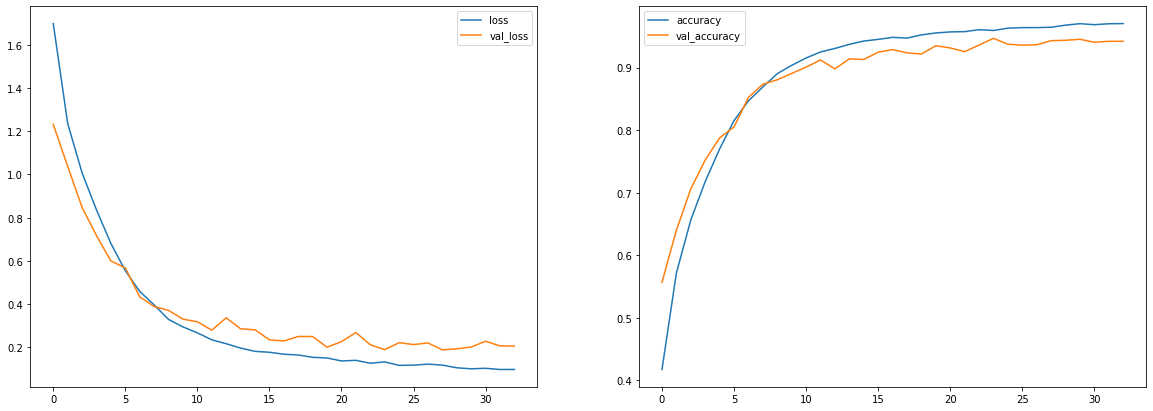

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df[['loss', 'val_loss']].plot(ax=axes[0], figsize=(20,7))
df[['accuracy', 'val_accuracy']].plot(ax=axes[1])

In [15]:
from sklearn.metrics import classification_report,confusion_matrix

In [16]:
pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


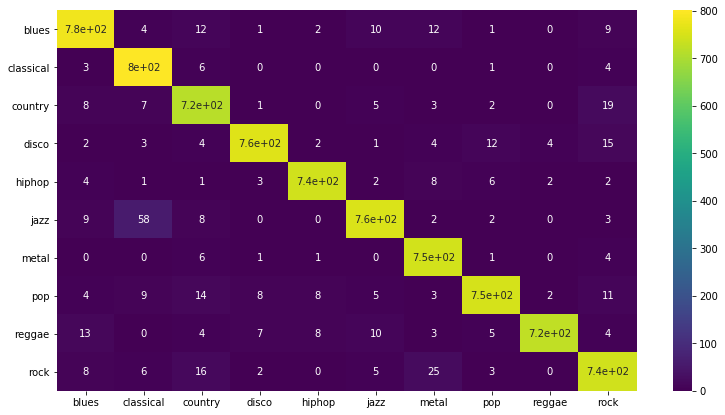

In [17]:
matrix = confusion_matrix(y_test,pred)

plt.figure(figsize=(13,7))
sns.heatmap(matrix, cmap="viridis", annot=True, xticklabels=cats, yticklabels=cats)

In [18]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       836
           1       0.90      0.98      0.94       815
           2       0.91      0.94      0.93       761
           3       0.97      0.94      0.96       810
           4       0.97      0.96      0.97       773
           5       0.95      0.90      0.93       839
           6       0.93      0.98      0.95       759
           7       0.96      0.92      0.94       812
           8       0.99      0.93      0.96       777
           9       0.91      0.92      0.92       807

    accuracy                           0.94      7989
   macro avg       0.94      0.94      0.94      7989
weighted avg       0.94      0.94      0.94      7989



**Fantastic! We were able to obtain an accuracy of 96% on our training data and 94% on our validation data, which is even better than what we got from features_3_sec.csv!**

## Testing one random song

We will pick a song at random from our directory and check its genre using our model

In [21]:
import os
import IPython.display as ipd
import librosa

def get_random_mfcc():
    # Select a song fropm the directory
    genre_index = np.random.randint(0,10)
    selected_genre = cats[genre_index]

    song_index = np.random.randint(0,100)
    selected_song = os.listdir('Data/genres_original/' + selected_genre)[song_index]

    selected_song_path = 'Data/genres_original/' + selected_genre + '/' + selected_song
    
    # Obtain mfcc from audio file and format it so it can be passed into the model
    signal, sr = librosa.load(path=selected_song_path, sr=22050)
    samples_per_segment = int(22050 * 30 / 10)

    mfcc = librosa.feature.mfcc(signal[:samples_per_segment], sr=sr, n_fft=2048, n_mfcc=13, hop_length=512)                
    mfcc = mfcc.T
    # (num_of_samples, 130, 13, number_of_color_channels)
    mfcc = mfcc.reshape(1, mfcc.shape[0], mfcc.shape[1], 1)
    
    return mfcc, selected_song_path, selected_genre
    

In [22]:
test_song, test_path, test_label = get_random_mfcc()
print(test_label)
print()
ipd.Audio(test_path)

hiphop



In [23]:
prediction = model.predict_classes(test_song)[0]
print('Predicted genre: ' + cats[prediction])

Predicted genre: hiphop
